In [49]:
import os
import random
import string
from collections import Counter, defaultdict
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [50]:
# Define paths
images_path = 'data/Images'
captions_file = 'data/captions.txt'

In [51]:
# Creates a dictionary, with the image name as the key, and the caption as the value
captions = defaultdict(list)
with open(captions_file, 'r') as f:
    next(f)  # Skip the header
    for line in f:
        image, caption = line.strip().split(',', 1)
        captions[image].append(caption)

In [52]:
captions['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [53]:
# Preprocess captions
def clean_caption(caption):
    # Remove punctuation
    caption = caption.translate(str.maketrans('', '', string.punctuation))
    # Remove words with numbers and words of length 1
    # If the word is of length 1, or the word contains a digit, remove it from the cpation
    caption = ' '.join([word for word in caption.split() if len(word) > 1 and not any(char.isdigit() for char in word)])
    # Convert to lowercase
    caption = caption.lower()
    return caption


In [54]:
# Surprisingly loops over all keys
for image in captions:
    # Loops over all strings, and cleans the captions
    captions[image] = [clean_caption(caption) for caption in captions[image]]

In [55]:
# Define image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # TODO: Update this part of the function
    transforms.Lambda(lambda x: x[:3, :, :]),  # Ensure the image has 3 channels
])

def load_image(image_file):
    image = Image.open(os.path.join(images_path, image_file)).convert('RGB')
    image = transform(image)
    return image

In [56]:
# Build vocabulary
word_counter = Counter()
for image, caption_list in captions.items():
    # Loops through list of strings
    for caption in caption_list:
        word_counter.update(caption.split())

In [57]:
# Create dictionaries
vocab_threshold = 3
vocab = [word for word, count in word_counter.items() if count > vocab_threshold]
vocab_size = len(vocab) + 4  # Including <PAD>, <START>, <END>, <UNK>

In [58]:
stoi = {word: idx + 4 for idx, word in enumerate(vocab)}
stoi['<PAD>'] = 0
stoi['<START>'] = 1
stoi['<END>'] = 2
stoi['<UNK>'] = 3

In [59]:
itos = {idx: word for word, idx in stoi.items()}

In [60]:
def encode_caption(caption):
    # Default entry for dictionary.get()
    encoded = [stoi['<START>']] + [stoi.get(word, stoi['<UNK>']) for word in caption.split()] + [stoi['<END>']]
    return encoded

def decode_caption(encoded_caption):
    # Default entry for dictionary.get()
    return ' '.join([itos.get(idx, '<UNK>') for idx in encoded_caption])

In [61]:
# Tokenize and pad captions
# To unpack this, we are looping over the defaultdict captions. We get the list of strings called caption_list, and loop over all lists of strings in captions, and also loop over all captions in the list
# This is a very complex string comprehension
max_length = max(len(caption.split()) for caption_list in captions.values() for caption in caption_list) + 2

In [62]:
def pad_caption(caption, max_length):
    return caption + [stoi['<PAD>']] * (max_length - len(caption))

In [63]:
encoded_captions = defaultdict(list)

In [64]:
for image in captions:
    for caption in captions[image]:
        encoded = encode_caption(caption)
        padded = pad_caption(encoded, max_length)
        encoded_captions[image].append(padded)

In [66]:
# Function to create input and target sequences
def create_sequences(encoded_caption):
    input_sequence = encoded_caption[:-1]
    target_sequence = encoded_caption[1:]
    return input_sequence, target_sequence

In [65]:
# Create input and target sequences for all captions
input_sequences = defaultdict(list)
target_sequences = defaultdict(list)

In [ ]:
for image, caption_list in encoded_captions.items():
    for caption in caption_list:
        # Loop through all captions in all caption_lists, and create the corresponding token lists
        input_seq, target_seq = create_sequences(caption)
        # Create another defaultdict() that allows for indexing of the processed list tokens
        input_sequences[image].append(input_seq)
        target_sequences[image].append(target_seq)

In [68]:
# Function to create a random batch
def create_batch(batch_size):
    images_batch = []
    input_captions_batch = []
    target_captions_batch = []

    # Sample at random any of the images
    selected_images = random.sample(list(captions.keys()), batch_size)

    for image in selected_images:
        # Pick a random nindex from one of the caption lists
        selected_caption_idx = random.randint(0, len(captions[image]) - 1)
        # Add the corresponding image caption
        input_captions_batch.append(input_sequences[image][selected_caption_idx])
        # Get the corresponding target_caption
        target_captions_batch.append(target_sequences[image][selected_caption_idx])
        # Add the image to the corresponding image to the image set
        images_batch.append(load_image(image))
    
    images_batch = torch.stack(images_batch)
    input_captions_batch = torch.tensor(input_captions_batch)
    target_captions_batch = torch.tensor(target_captions_batch)
    
    return images_batch, input_captions_batch, target_captions_batch

In [69]:
# Example usage:
batch_size = 64
images_batch, input_captions_batch, target_captions_batch = create_batch(batch_size)


In [71]:
images_batch.shape

torch.Size([64, 3, 224, 224])

In [72]:
input_captions_batch.shape

torch.Size([64, 34])

In [74]:
target_captions_batch.shape

torch.Size([64, 34])

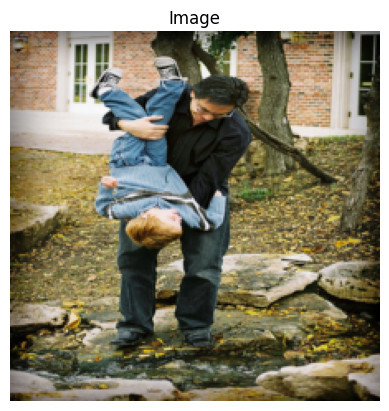

Input Caption: <START> man plays with little boy holding him upside down <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target Caption: man plays with little boy holding him upside down <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [73]:
def visualize_example():
    # Select a random image
    random_image = random.choice(list(captions.keys()))
    
    # Select a random caption index for the chosen image
    caption_idx = random.randint(0, len(captions[random_image]) - 1)
    
    # Load the image
    image_tensor = load_image(random_image)
    image_array = image_tensor.permute(1, 2, 0).numpy()
    
    # Get the input and target sequences
    input_caption_encoded = input_sequences[random_image][caption_idx]
    target_caption_encoded = target_sequences[random_image][caption_idx]
    
    # Decode the captions
    input_caption = decode_caption(input_caption_encoded)
    target_caption = decode_caption(target_caption_encoded)
    
    # Plot the image
    plt.imshow(image_array)
    plt.axis('off')
    plt.title('Image')
    plt.show()
    
    # Print the input and target captions
    print(f"Input Caption: {input_caption}")
    print(f"Target Caption: {target_caption}")

# Example usage:
visualize_example()


In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

    def forward(self, inputs):
        

In [ ]:
class Decoder(nn.Module):
    def __init__(self, emb_size, num_layers = 1, emb_size, hidden_size):
        super(Decoder, self).__init__()

        self.lstm = nn.LSTM(input_size=emb_size, hidden_size=hidden_size, num_layers=num_layers, bias = True, batch_first=True)

    # Memory in will always be a matrice of zeros
    def forward(self, inputs, hidden_in, mem_in):
        outputs, (hidden_out, mem_out) = self.lstm(x, (hidden_in, mem_in))
        # x = (B, T, emb_size)
        # hidden_out = (num_layers, B, hidden_size)
        # mem_out = (num_layers, B, hidden_size)

In [ ]:
memory = torch.zeros(num_layers, bs, hidden_size, device=device)